In [1]:
# General
import os
import shutil
from collections import Counter
from tempfile import mkdtemp
from shutil import rmtree
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    SelectKBest, VarianceThreshold, f_classif)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Input, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model

# Custom
from data_io import read_data
from utils import label_map, normalize

from livelossplot import PlotLossesKeras

In [3]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Load data

In [4]:
texts_train, labels_train = read_data(mode='train')
y_train_full = np.asarray([label_map[label] for label in labels_train])

In [5]:
texts_val, labels_val = read_data(mode='val')
y_val_full = np.asarray([label_map[label] for label in labels_val])

In [6]:
texts_test, labels_test = read_data(mode='test')
y_test_full = np.asarray([label_map[label] for label in labels_test])

### Configuration

In [8]:
# adjusted label map to account for padding
label_map = {
    'BACKGROUND': 0,
    'CONCLUSIONS': 1,
    'METHODS': 2,
    'OBJECTIVE': 3,
    'RESULTS': 4,
    'PAD': 5
}

In [9]:
N_CLASSES = 6 # 5 + dummy

In [10]:
MAX_LENGTH_ABSTRACT = 51

#### Prepare Label Encoder
(Consider padding class)

In [11]:
labelencoder = LabelBinarizer()
labelencoder.classes_ = np.array([0, 1, 2, 3, 4, 5], dtype=object)

#### Load BERT sentence embeddings
Pooled sentence embeddings from pretrained and fine-tuned BERT language model

In [14]:
embed_train = np.load("./data/train_bert_finetuned_1epoch_embed_unnormalized_preprocessed.npy", allow_pickle=True)
embed_val = np.load("./data/val_bert_finetuned_1epoch_embed_unnormalized_preprocessed.npy", allow_pickle=True)
embed_test = np.load("./data/test_bert_finetuned_1epoch_embed_unnormalized_preprocessed.npy", allow_pickle=True)

### Load entire abstracts

In [15]:
_, _, train_abstract_texts, train_abstract_targets = read_data(mode='train', return_abstracts=True)

In [16]:
_, _, val_abstract_texts, val_abstract_targets = read_data(mode='val', return_abstracts=True)

In [17]:
_, _, test_abstract_texts, test_abstract_targets = read_data(mode='test', return_abstracts=True)

#### Build list of embeddings for eac abstract

In [20]:
def create_embedding_abstracts(abstract_text, sentence_embeddings):
    
    start = 0
    abstract_embeddings = []
    for a in tqdm(abstract_text):
        
        l = len(a)
        abstract_embeddings.append(sentence_embeddings[start:start+l])
        start = start + l
        
    # Sanity check
    check = map(lambda x: 0 if len(x[0]) == len(x[1]) else 1, zip(abstract_text, abstract_embeddings))
    assert sum(check) == 0, "Created abstract lengths of embeddings don't match"
    
    return abstract_embeddings

In [21]:
# Create list of abstracts with embeddings
train_abstract_embed = create_embedding_abstracts(train_abstract_texts, embed_train)
val_abstract_embed = create_embedding_abstracts(val_abstract_texts, embed_val)
test_abstract_embed = create_embedding_abstracts(test_abstract_texts, embed_test)

  0%|          | 0/190654 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

##### Find the maximum lengt abstract

In [22]:
# Find max length abstract
print("Train max length abstract: ", max(map(lambda x: len(x), train_abstract_embed)))
print("Val max length abstract: ", max(map(lambda x: len(x), val_abstract_embed)))
print("Test max length abstract: ", max(map(lambda x: len(x), test_abstract_embed)))

Train max length abstract:  51
Val max length abstract:  28
Test max length abstract:  28


#### Pad abstracts to maximum length wit 0 embeddings and padding class

In [23]:
def pad_to_maxlen(text, labels, maxlen=MAX_LENGTH_ABSTRACT):

    text_out = []
    labels_out = []
    for t, l in tqdm(zip(text, labels), total=len(text)):
        
        if len(t) < maxlen:
            padded_text = np.concatenate((t, np.array([np.zeros(768) for i in range(maxlen-len(t))])), axis=0)
            text_out.append(padded_text)
            labels_out.append(np.concatenate((l, np.array(['PAD' for i in range(maxlen-len(l))])), axis=0))
        else:
            text_out.append(t)
            labels_out.append(l)
        
    return text_out, labels_out

In [24]:
# pad to match longest abstract
train_abstract_embed_pad, train_abstract_targets_pad = pad_to_maxlen(train_abstract_embed, train_abstract_targets)
val_abstract_embed_pad, val_abstract_targets_pad = pad_to_maxlen(val_abstract_embed, val_abstract_targets)
test_abstract_embed_pad, test_abstract_targets_pad = pad_to_maxlen(test_abstract_embed, test_abstract_targets)

  0%|          | 0/190654 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

#### One-Hot encode class labels (incl. padding class)

In [25]:
# Label Encoding
train_abstract_targets_pad = [labelencoder.transform([label_map[label] for label in x]) for x in tqdm(train_abstract_targets_pad)]
val_abstract_targets_pad = [labelencoder.transform([label_map[label] for label in x]) for x in tqdm(val_abstract_targets_pad)]
test_abstract_targets_pad = [labelencoder.transform([label_map[label] for label in x]) for x in tqdm(test_abstract_targets_pad)]

  0%|          | 0/190654 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

#### Create TF Datasets

In [26]:
train_abstract_embed_ds = tf.data.Dataset.from_generator(lambda: train_abstract_embed_pad, tf.float32, output_shapes=(51, 768))
val_abstract_embed_ds = tf.data.Dataset.from_generator(lambda: val_abstract_embed_pad, tf.float32, output_shapes=(51, 768))
test_abstract_embed_ds = tf.data.Dataset.from_generator(lambda: test_abstract_embed_pad, tf.float32, output_shapes=(51, 768))

In [27]:
y_train_ds = tf.data.Dataset.from_generator(lambda: train_abstract_targets_pad, tf.int32, output_shapes=(51, 6))
train_ds = tf.data.Dataset.zip((train_abstract_embed_ds, y_train_ds))

y_val_ds = tf.data.Dataset.from_generator(lambda: val_abstract_targets_pad, tf.int32, output_shapes=(51, 6))
val_ds = tf.data.Dataset.zip((val_abstract_embed_ds, y_val_ds))

y_test_ds = tf.data.Dataset.from_generator(lambda: test_abstract_targets_pad, tf.int32, output_shapes=(51, 6))
test_ds = tf.data.Dataset.zip((test_abstract_embed_ds, y_test_ds))

In [90]:
# Check length
# print("Train max length abstract: ", max(map(lambda x: len(x), train_abstract_embed_pad)))
# print("Val max length abstract: ", max(map(lambda x: len(x), val_abstract_embed_pad)))
# print("Test max length abstract: ", max(map(lambda x: len(x), test_abstract_embed_pad)))

### RNN Training
Build a bidirectional RNN to predict a complete label sequence for each abstract

In [65]:
def sentence_classifier(embeddingsize=768):
    
    inputs = Input(shape=(51, embeddingsize,))
    
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(inputs)
    
    x = Dense(32, activation='relu')(x)
    
    output = Dense(N_CLASSES, activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=output)
    
    return model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 51, 768)]         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 51, 128)           426496    
_________________________________________________________________
dense_2 (Dense)              (None, 51, 32)            4128      
_________________________________________________________________
dense_3 (Dense)              (None, 51, 6)             198       
Total params: 430,822
Trainable params: 430,822
Non-trainable params: 0
_________________________________________________________________


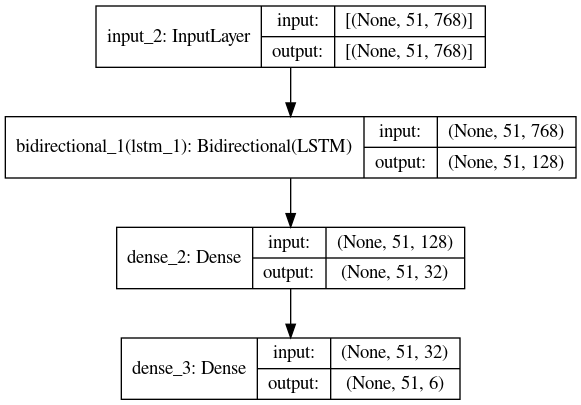

In [66]:
sentence_model = sentence_classifier()

sentence_model.summary()
tf.keras.utils.plot_model(sentence_model, show_shapes=True)

#### Compile model

In [67]:
sentence_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#### Custom Metric Callback
to monitor relevant scores on the entire validation set

In [68]:
class MetricCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X, y):
        
        self.X = X
        self.y = y

    def on_epoch_end(self, epoch, logs=None):
        
        y_proba = self.model.predict(self.X.batch(64))
        y_pred_out = []
        y_true_out = []
        for true, proba in zip(self.y, y_proba):

            length = len(true)
            cut = proba[:length]
            
            labels = np.argmax(np.array(cut), axis=1)
            labels_second = np.argsort(np.array(cut), axis=-1)[:,-2]

        
#             labels = [4 if l == 5 else l for l in labels] # impute with majority class
            labels = [l_sec if l == 5 else l for l, l_sec in zip(labels, labels_second)] # impute with second highest prob.
            
            y_pred_out = y_pred_out + labels

            y_true_out = y_true_out + [label_map[label] for label in true]

        y_pred = y_pred_out
        y_true = y_true_out

        f1_macro = f1_score(y_true, y_pred, average="macro")
        f1_weighted = f1_score(y_true, y_pred, average="weighted")
        f1_micro = f1_score(y_true, y_pred, average="micro")
        bac = balanced_accuracy_score(y_true, y_pred)
        
        print(f"Epoch {epoch} validation scores -> F1 (weighted): {f1_weighted}, F1 (micro): {f1_micro}, BAC: {bac}")
        
        logs["val_f1_macro"] = f1_macro
        logs["val_f1_weighted"] = f1_weighted
        logs["val_f1_micro"] = f1_micro
        logs["val_bac"] = bac

#### Training
- Use early stopping to prevent overfitting

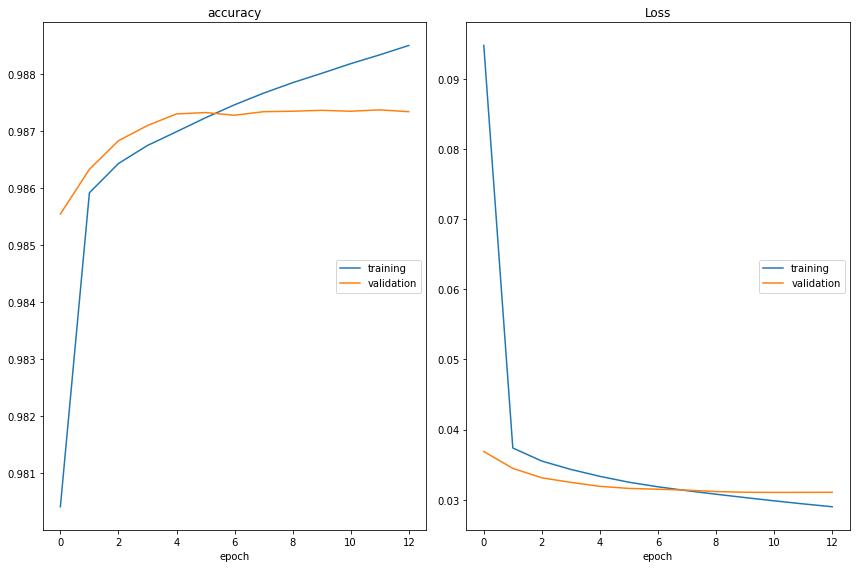

accuracy
	training         	 (min:    0.980, max:    0.989, cur:    0.989)
	validation       	 (min:    0.986, max:    0.987, cur:    0.987)
Loss
	training         	 (min:    0.029, max:    0.095, cur:    0.029)
	validation       	 (min:    0.031, max:    0.037, cur:    0.031)
Epoch 12 validation scores -> F1 (weighted): 0.9440071318563177, F1 (micro): 0.9442140190792202, BAC: 0.9021946735499137
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping


In [69]:
BATCH_SIZE = 512
EPOCHS = 15

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, verbose=1,
    mode='min', restore_best_weights=True
)

history = sentence_model.fit(
    x=train_ds.batch(BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=val_ds.batch(BATCH_SIZE),
    callbacks=[
        PlotLossesKeras(),
        MetricCallback(val_ds, val_abstract_targets),
        es_callback
    ],
    verbose=1
)

#### Plot F1 score training progression

<AxesSubplot:xlabel='epochs'>

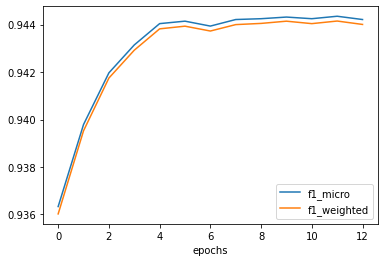

In [91]:
data = {
    "epochs": list(range(len(history.history["loss"]))),
    "loss" : history.history["loss"],
    "val_loss" : history.history["val_loss"],
    "f1_weighted" : history.history["val_f1_weighted"],
    "f1_micro" : history.history["val_f1_micro"],
#     "bac" : history.history["val_bac"],
}

df = pd.DataFrame(data)

df.plot(x="epochs", y=["f1_micro", "f1_weighted"])

#### Store model
Please reach out to us, if you would like the trained model for examination

In [ ]:
# sentence_model.save("./models/sentence_model_bert_finetuned_embeddings_final")

### Evaluate and store predictions
During prediction we cut the sequences back to original length, predicted padding classes within the abstracts are replaced with the class with the second highest probability according to the model

In [85]:
def predict_score_remove_padding(y_true, X, model=sentence_model, store_pred=False, split=None):
    
    y_proba = model.predict(X.batch(64))
    y_pred_out = []
    y_true_out = []
    for true, proba in tqdm(zip(y_true, y_proba), total=len(y_true)):
        
        length = len(true)
        cut = proba[:length]
        
        labels = np.argmax(np.array(cut), axis=1)
        labels_second = np.argsort(np.array(cut), axis=-1)[:,-2]
        
#         labels = [4 if l == 5 else l for l in labels] # impute with majority class
        labels = [l_sec if l == 5 else l for l, l_sec in zip(labels, labels_second)] # impute with second highest prob.
        
        y_pred_out = y_pred_out + labels

        y_true_out = y_true_out + [label_map[label] for label in true]
    
    if store_pred and split:
        print(f"Store {split}", np.array(y_pred_out).shape)
        np.save(f"./predictions/{split}_sentence_model_bert_finetuned_embeddings", np.array(y_pred_out), allow_pickle=True)
    
    score_weigh = f1_score(y_true_out, y_pred_out, average="weighted")
    score_micro = f1_score(y_true_out, y_pred_out, average="micro")
    print(f"F1 (weigh): {score_weigh}, F1 (micro): {score_micro}")
    
    return score_weigh, score_micro

In [86]:
predict_score_remove_padding(val_abstract_targets, val_ds, store_pred=True, split="val")

  0%|          | 0/2500 [00:00<?, ?it/s]

Store val (28932,)
F1 (weigh): 0.9440409135026058, F1 (micro): 0.9442485828840038


(0.9440409135026058, 0.9442485828840038)

In [87]:
predict_score_remove_padding(test_abstract_targets, test_ds, store_pred=True, split="test")

  0%|          | 0/2500 [00:00<?, ?it/s]

Store test (29493,)
F1 (weigh): 0.9436625162728972, F1 (micro): 0.9438510833079036


(0.9436625162728972, 0.9438510833079036)

In [88]:
predict_score_remove_padding(train_abstract_targets, train_ds, store_pred=True, split="train")

  0%|          | 0/190654 [00:00<?, ?it/s]

Store train (2211861,)
F1 (weigh): 0.9480378506046654, F1 (micro): 0.9482200735037147


(0.9480378506046654, 0.9482200735037147)